In [3]:
!pip3 install torch 
!pip3 install torchvision
!pip3 install tqdm
!pip install pbd
!pip install Pillow==4.0.0
!pip install PIL
!pip install image

    100% |████████████████████████████████| 519.5MB 31kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59c5c000 @  0x7f7ea38a31c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 2.7MB/s 
    100% |████████████████████████████████| 2.0MB 7.9MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
  Running setup.py bdist_wheel for pbd ... - done
  Stored in directory: /root/.cache/pip/wheels/27/d2/a5/caefc1f51c049318659cfe9d699d4ba10c3f084fc925d8c533
Successfully built pbd
    100% |████████████████████████████████| 5.6MB 5.3MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing inst

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
assert torch.cuda.is_available() # You need to request a GPU from Runtime > Change Runtime Type
from torch.nn.parameter import Parameter
import pdb
 # Load the Drive helper and mount
from google.colab import drive
# drive.mount('/gdrive')

import torchvision
import os
import gzip
import gc
import tarfile
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode= "Verbose", color_scheme='LightBg', tb_offset=1)

In [0]:
class CancerDataset(Dataset):
  def __init__(self, root, download=True, size=512, train=True):
    if download and not os.path.exists(os.path.join(root, 'cancer_data')):
      datasets.utils.download_url('http://liftothers.org/cancer_data.tar.gz', root, 'cancer_data.tar.gz', None)
      self.extract_gzip(os.path.join(root, 'cancer_data.tar.gz'))
      self.extract_tar(os.path.join(root, 'cancer_data.tar'))
 
    postfix = 'train' if train else 'test'
    root = os.path.join(root, 'cancer_data', 'cancer_data')
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'inputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))
    self.label_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'outputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))
 
  @staticmethod
  def extract_gzip(gzip_path, remove_finished=False):
    print('Extracting {}'.format(gzip_path))
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
      out_f.write(zip_f.read())
    if remove_finished:
      os.unlink(gzip_path)
 
  @staticmethod
  def extract_tar(tar_path):
    print('Untarring {}'.format(tar_path))
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))
 
 
  def __getitem__(self,index):
    img = self.dataset_folder[index]
    label = self.label_folder[index]
    return img[0],label[0][0]
 
  def __len__(self):
    return len(self.dataset_folder)

In [38]:
class TwoConv2d(nn.Module):
  def __init__(self, in_ch, out_ch):
    super(TwoConv2d, self).__init__()
    self.net = nn.Sequential(
        nn.BatchNorm2d(in_ch),
        nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(out_ch),
        nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1,padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU())
    
  def forward(self, input):
    return self.net(input)
  
  
class UpConv(nn.Module):
  def __init__(self, in_ch, out_ch):
    super(UpConv, self).__init__()
    self.up_conv = nn.Sequential(
        nn.BatchNorm2d(in_ch),
        nn.ConvTranspose2d(in_ch, out_ch, 4, 2, 1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU())
    
  def forward(self, input):
    return self.up_conv(input)


class CancerDetector(nn.Module):
  def __init__(self, dataset):
    super(CancerDetector, self).__init__()
#     x, y = dataset[0]
#     c, h, w = x.size()
#     output = 150
    
    self.max_pool = nn.MaxPool2d(2)
    
    self.conv1 = TwoConv2d(3,64)
    self.conv2 = TwoConv2d(64,128)
    self.conv3 = TwoConv2d(128,256)
    self.conv4 = TwoConv2d(256,512)
    
    self.conv_bottom = TwoConv2d(512,1024)    
 
    self.up_conv4 = UpConv(1024,512)
    self.up_conv3 = UpConv(512,256)
    self.up_conv2 = UpConv(256,128)
    self.up_conv1 = UpConv(128,64)
    
    
    self.conv4_ = TwoConv2d(1024,512)
    self.conv3_ = TwoConv2d(512,256)
    self.conv2_ = TwoConv2d(256,128)
    self.conv1_ = TwoConv2d(128,64)
    
    self.final_conv = nn.Sequential(nn.Conv2d(64,2,1,1,0),
                                   nn.Sigmoid())
    
  def forward(self, input):
    
    conv1_out = self.conv1(input)
    conv2_out = self.conv2(self.max_pool(conv1_out))
    conv3_out = self.conv3(self.max_pool(conv2_out))
    conv4_out = self.conv4(self.max_pool(conv3_out))
    
    conv_bottom_out = self.conv_bottom(self.max_pool(conv4_out))
    
    conv4__out = self.conv4_(torch.cat((self.up_conv4(conv_bottom_out), conv4_out), 1))
    conv3__out = self.conv3_(torch.cat((self.up_conv3(conv4__out), conv3_out), 1))
    conv2__out = self.conv2_(torch.cat((self.up_conv2(conv3__out), conv2_out), 1))
    conv1__out = self.conv1_(torch.cat((self.up_conv1(conv2__out), conv1_out), 1))
    
    
    return self.final_conv(conv1__out)
  
  
def scope():
#   try: 

  
  objective = nn.CrossEntropyLoss()

  train_dataset = CancerDataset('./', size=512, train=True )
  validation_dataset = CancerDataset('./', size=512, train=False)

  train_loader = DataLoader(train_dataset,
                         batch_size=1,
                         pin_memory=True,
                         shuffle=True)

  validation_loader = DataLoader(validation_dataset,
                                 batch_size=1,
                                 pin_memory=True,
                                 shuffle=True)
  training_losses = []
  train_accuracys = []

  validation_losses = []
  validation_accuracys = []
  
  model = CancerDetector(train_dataset)
  model.cuda()
  optimizer = optim.Adam(model.parameters(), lr=1e-4)
  
  for epoch in range(10):
    
    loop = tqdm(total=len(train_loader), position=0)
    
    training_loss = []
    training_accuracy = []
    for i,(x,y_truth) in enumerate(train_loader):
      
      gc.collect() 

      x = x.cuda(async=True)
      y_truth = y_truth.cuda(async=True ).long()

      optimizer.zero_grad()

      y_hat = model(x)
      loss = objective(y_hat, y_truth)
#       print("Doing Loop")
    #     break
      loss.backward()
      
      training_loss.append(loss.item())
      training_accuracy.append(y_truth.eq(torch.argmax(y_hat, 1)).float().mean().item())
#       print(training_loss[-1])
#       print(training_accuracy[-1])
#       break
      
      loop.set_description('Epoch:{}, Loss:{:.4f}, Accuracy:{:.3f}, Training Loop'.format(epoch+1, training_loss[-1], training_accuracy[-1]))
      loop.update(1)

      optimizer.step()

      with torch.no_grad():

        if(i % 500 == 0):
          validation_loss = []
          validation_accuracy = []

          val_loop = tqdm(total=len(validation_loader), position=0)
          for j, (val_x1,val_y1_truth) in enumerate(validation_loader):
            val_x1 = val_x1.cuda(async=True)
            val_y1_truth = val_y1_truth.cuda(async=True ).long()
#             print("Validation Loop")
            val_y1_hat = model(val_x1)
            v_loss = objective(val_y1_hat, val_y1_truth)

            validation_loss.append(v_loss.item())
            validation_accuracy.append(val_y1_truth.eq(torch.argmax(val_y1_hat, 1).long()).float().mean())
        
            val_loop.set_description('Epoch:{}, Loss:{:.4f}, Accuracy:{:.3f}, Validation Loop'.format(epoch+1, validation_loss[-1], validation_accuracy[-1]))
            val_loop.update(1)
          
          validation_losses.append((len(training_losses), sum(validation_loss)/len(validation_loss)))
          validation_accuracys.append((len(training_losses), sum(validation_accuracy )/len(validation_accuracy )))

          

          val_loop.close()

    training_losses.append((len(training_losses), sum(training_loss)/len(training_loss)))
    train_accuracys.append((len(training_losses), (sum(training_accuracy)/len(training_accuracy))))

#     epochs.append((training_losses, validation_losses, sum([np.prod(p.size()) for p in  model.parameters()]), train_accuracys, val_accuracys))

  loop.close()
#   except:
#     __ITB__()
    
  
  return model, objective, sum([np.prod(p.size()) for p in  model.parameters()]), training_losses, train_accuracys, validation_losses, validation_accuracys
model, objective, params, training_losses, train_accuracys, validation_losses, validation_accuracys = scope()
print("done")


Epoch:1, Loss:0.6698, Accuracy:0.790, Validation Loop: 100%|██████████| 175/175 [01:25<00:00,  1.99it/s]
Epoch:1, Loss:0.5213, Accuracy:0.989, Validation Loop: 100%|██████████| 175/175 [01:25<00:00,  2.06it/s]
Epoch:1, Loss:0.4963, Accuracy:0.899, Validation Loop: 100%|██████████| 175/175 [01:25<00:00,  2.04it/s]
Epoch:2, Loss:0.4026, Accuracy:0.999, Validation Loop: 100%|██████████| 175/175 [01:25<00:00,  2.04it/s]
Epoch:2, Loss:0.3698, Accuracy:0.994, Validation Loop: 100%|██████████| 175/175 [01:25<00:00,  2.03it/s]
Epoch:2, Loss:0.3480, Accuracy:0.998, Validation Loop: 100%|██████████| 175/175 [01:25<00:00,  2.12it/s]
Epoch:3, Loss:0.3417, Accuracy:0.996, Validation Loop: 100%|██████████| 175/175 [01:25<00:00,  2.04it/s]
Epoch:3, Loss:0.3343, Accuracy:0.998, Validation Loop: 100%|██████████| 175/175 [01:25<00:00,  2.03it/s]
Epoch:3, Loss:0.4009, Accuracy:0.931, Validation Loop: 100%|██████████| 175/175 [01:25<00:00,  2.05it/s]
Epoch:4, Loss:0.3261, Accuracy:0.997, Validation Loop: 

done


39410952


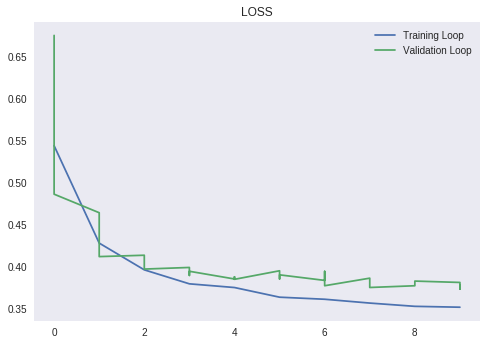

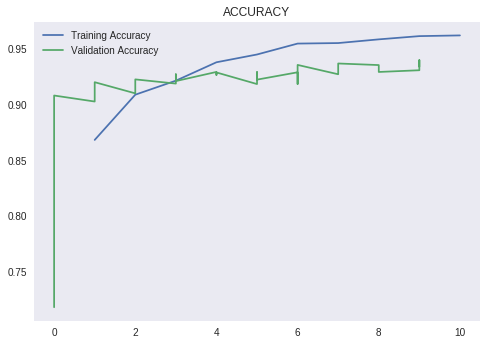

In [39]:
print(params)

loss_x, loss_y = zip(*training_losses)
plt.plot(loss_x, loss_y, label='Training Loop')
val_loss_x, val_loss_y = zip(*validation_losses)
plt.plot(val_loss_x, val_loss_y, label='Validation Loop')
plt.legend()
plt.title("LOSS")
plt.show()

acc_x, acc_y = zip(*train_accuracys)
plt.plot(acc_x, acc_y, label='Training Accuracy')
val_acc_x, val_acc_y = zip(*validation_accuracys)
plt.plot(val_acc_x, val_acc_y, label='Validation Accuracy')
plt.legend()
plt.title("ACCURACY")
plt.show()

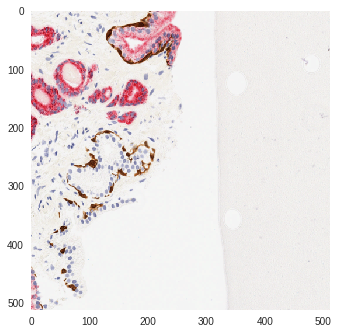

In [40]:
objective = nn.CrossEntropyLoss()
import torch as t
from torchvision.transforms import ToPILImage
from IPython.display import Image
to_img = ToPILImage()

testset = CancerDataset(root='./', train = False)
final_test_img = testset[172][0]
final_test_ig = final_test_img.unsqueeze(0).cuda()
final_test_label = testset[172][1].unsqueeze(0).cuda().long()

plt.imshow(to_img(final_test_img))

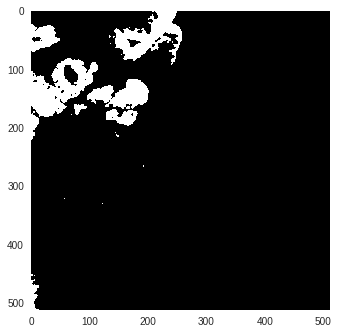

In [41]:
# !pip install Pillow
# !pip install PIL
import torch as t
from torchvision.transforms import ToPILImage
from IPython.display import Image
to_img = ToPILImage()


#Running into error displaying my image. Cant find any help or instruction on how to fix it
#but its there:
torch.argmax(img_y1_hat, 1).cpu().float().size()
y_hat = np.argmin(img_y1_hat.detach().squeeze().cpu().numpy(), axis=0)
plt.imshow(y_hat, interpolation='nearest')
plt.rcParams['axes.grid'] = False
plt.show()
